# License Plate Detection using YOLOv3

# Importing necessary libraries

In [1]:
from IPython.display import Image
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score
import cv2
import argparse
import sys
import imutils
import numpy as np
import pandas as pd
import os.path
import pytesseract
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam

In [2]:
#Enter path for the image to be tested
input_path = r'D:/Sheikfaizalnumberplate/test_dataset/images/1.jpg'

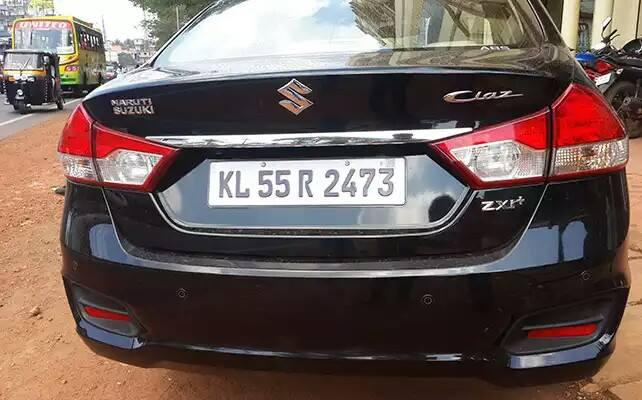

In [3]:
Image(input_path)

In [4]:
#Open the image file
cap = cv2.VideoCapture(input_path)
image1 = cv2.imread(input_path)

In [5]:
# Initialize the parameters

confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #Width of network's input image
inpHeight = 416     #Height of network's input image

In [6]:
# Load names of classes
classesFile = "D:\Sheikfaizalnumberplate\yolo_utils\yolo_utils\classes.names";

In [7]:
# Append all different classes into the list 'classes'
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

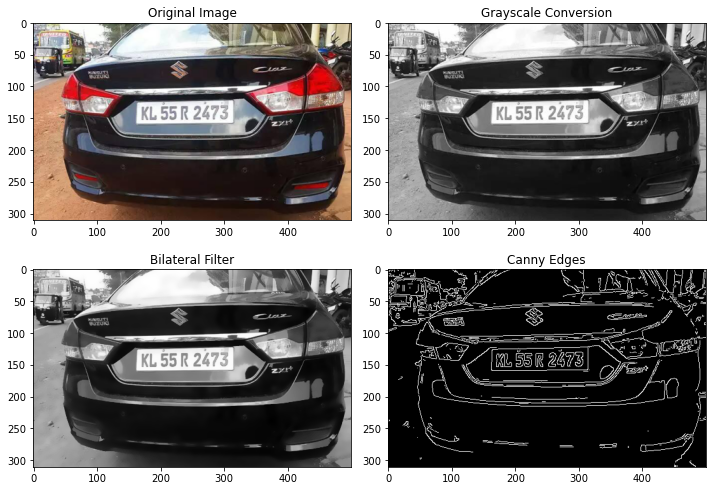

In [8]:
image1 = imutils.resize(image1 , width=500)
img=cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Display the original image
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# RGB to Gray scale conversion
gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

### Restore the neural network

In [9]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = r"D:\Sheikfaizalnumberplate\yolo_utils\yolo_utils\darknet-yolov3.cfg";
modelWeights = r"D:\Sheikfaizalnumberplate\yolo_utils\yolo_utils\lapi.weights";

In [10]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

### Define the post processing functions

In [11]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [12]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom, frame):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [13]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        #print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        # drawPred
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

### Plate Detection

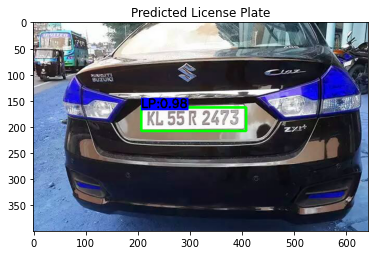

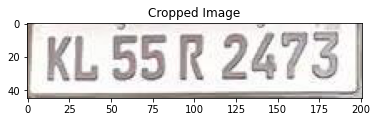

Done processing !!!


In [14]:
while cv2.waitKey(1) < 0:

    hasFrame, frame = cap.read() #frame: an image object from cv2

    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        break

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    cropped = postprocess(frame, outs)

    plt.imshow(frame)
    plt.title("Predicted License Plate")
    plt.show()
    plt.imshow(cropped)
    plt.title("Cropped Image")
    plt.show()

## Character Segmentation

In [15]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [16]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

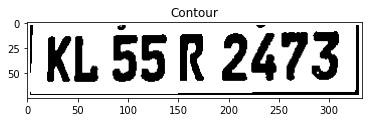

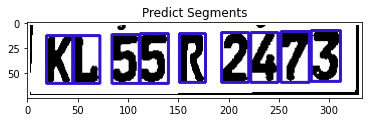

In [17]:
char=segment_characters(cropped)

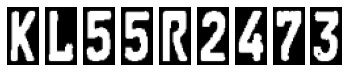

In [18]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

# Character Recognition using CNN

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'D:/Sheikfaizalnumberplate/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 1232 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [20]:
class_indices = train_generator.class_indices
# Get the class names from the indices
class_names = list(class_indices.keys())
# Print the class names
print(class_names)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_A', 'class_B', 'class_C', 'class_D', 'class_E', 'class_F', 'class_G', 'class_H', 'class_I', 'class_J', 'class_K', 'class_L', 'class_M', 'class_N', 'class_O', 'class_P', 'class_Q', 'class_R', 'class_S', 'class_T', 'class_U', 'class_V', 'class_W', 'class_X', 'class_Y', 'class_Z']


In [21]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics='accuracy')


C:\Users\sures\.conda\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [23]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 40, verbose=2, callbacks=None)

Epoch 1/40
1232/1232 - 14s - loss: 3.2725 - accuracy: 0.1015 - val_loss: 2.0228 - val_accuracy: 0.3611
Epoch 2/40
1232/1232 - 5s - loss: 2.0129 - accuracy: 0.4334 - val_loss: 0.7996 - val_accuracy: 0.7824
Epoch 3/40
1232/1232 - 4s - loss: 1.4715 - accuracy: 0.5990 - val_loss: 0.5581 - val_accuracy: 0.8287
Epoch 4/40
1232/1232 - 5s - loss: 1.2209 - accuracy: 0.6347 - val_loss: 0.4233 - val_accuracy: 0.8796
Epoch 5/40
1232/1232 - 5s - loss: 0.9220 - accuracy: 0.7159 - val_loss: 0.2034 - val_accuracy: 0.9491
Epoch 6/40
1232/1232 - 5s - loss: 0.7689 - accuracy: 0.7670 - val_loss: 0.1822 - val_accuracy: 0.9444
Epoch 7/40
1232/1232 - 5s - loss: 0.5975 - accuracy: 0.8182 - val_loss: 0.1509 - val_accuracy: 0.9583
Epoch 8/40
1232/1232 - 5s - loss: 0.5197 - accuracy: 0.8320 - val_loss: 0.1925 - val_accuracy: 0.9630
Epoch 9/40
1232/1232 - 5s - loss: 0.4498 - accuracy: 0.8547 - val_loss: 0.0887 - val_accuracy: 0.9676
Epoch 10/40
1232/1232 - 5s - loss: 0.3499 - accuracy: 0.8904 - val_loss: 0.1032 -

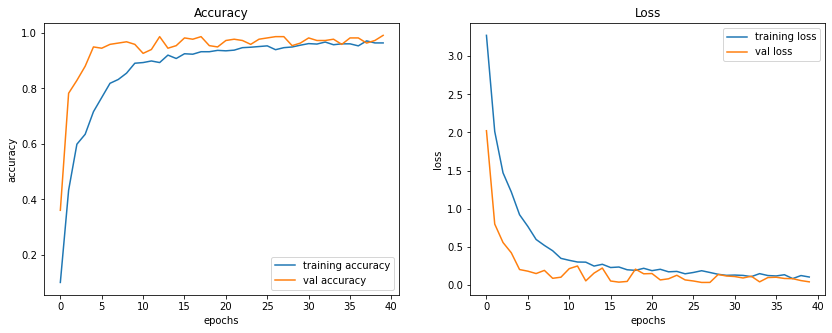

In [24]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [25]:
Ttest_loss, Ttest_acc = model.evaluate(train_generator, verbose=2)
Vtest_loss, Vtest_acc = model.evaluate(validation_generator, verbose=2)

1232/1232 - 4s - loss: 0.0656 - accuracy: 0.9732
7/7 - 0s - loss: 0.0461 - accuracy: 0.9815


Save the model weights for future use

In [26]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

In [27]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

In [28]:
print("The Accuracy Of The Trained CNN Model",Ttest_acc)
print("The Loss Of The Trained CNN Model",Ttest_loss)

The Accuracy Of The Trained CNN Model 0.9732142686843872
The Loss Of The Trained CNN Model 0.06561843305826187


## Saving Model

In [29]:
model.save("hybrid.h5")
print("Saved model to disk")

Saved model to disk


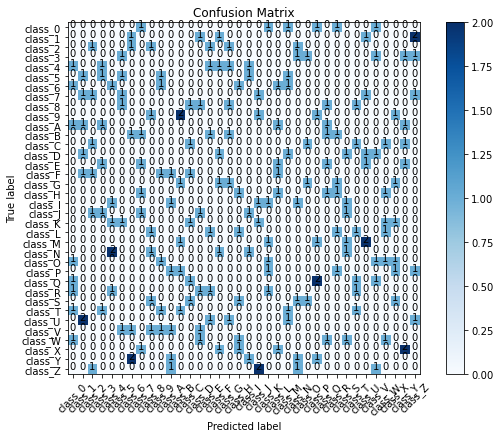

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Make predictions on the validation set
predictions = model.predict(validation_generator)
y_true = validation_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get the class labels
class_labels = validation_generator.class_indices
class_labels = list(class_labels.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Add text annotations
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Predict the license plate number

In [31]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_pred = model.predict(img)[0] #predicting the class
        y_ = np.argmax(y_pred)
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

KL55R2473


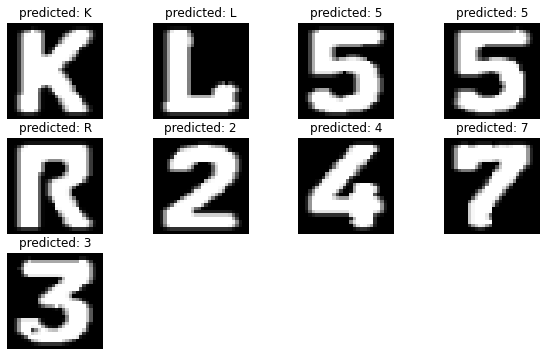

In [32]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## another method to predict number plate charecter

In [33]:
# Import modules
from PIL import Image
import pytesseract
 
# Include tesseract executable in your path
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\sures\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"
 
# Create an image object of PIL library
#image = Image.open(cropped)
 
# pass image into pytesseract module
# pytesseract is trained in many languages
image_to_text = pytesseract.image_to_string(cropped, lang='eng')
 
# Print the text
print(image_to_text)


KL55R 2473



# Importing the dataset

In [35]:
labels=pd.read_excel(r'D:\Sheikfaizalnumberplate\test_dataset\labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

ID       NUMBER
0      1    KL55R2473
1      2  GJW115A1138
2      3    KL16J3636
3      4   MH20EE7598
4      5      PJJ1L76
..   ...          ...
181  182      DHF5B15
182  183      DBJ5R59
183  184      LVY8X45
184  185      YYD6B61
185  186      CHI4A30

[186 rows x 2 columns]

# Accuracy

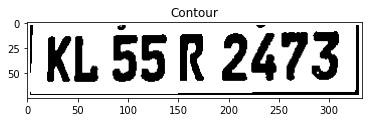

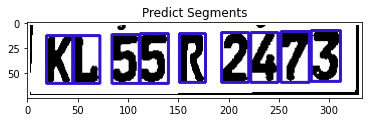

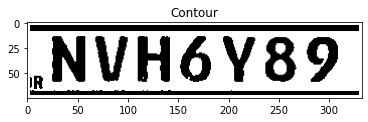

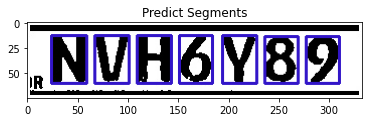

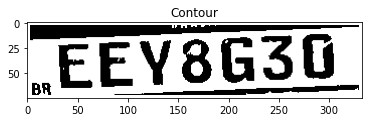

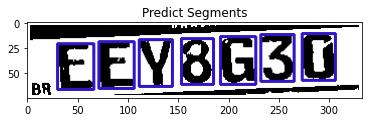

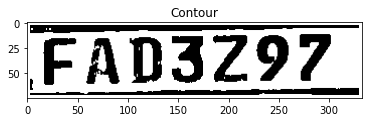

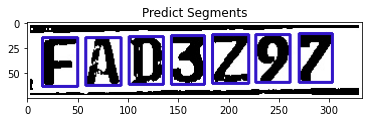

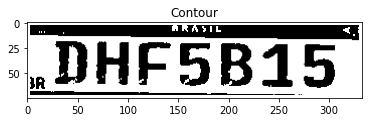

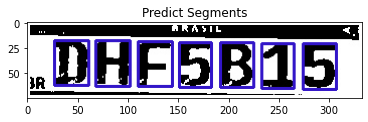

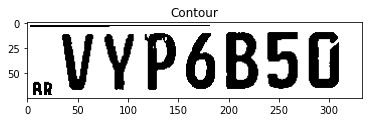

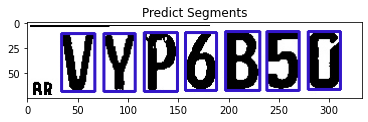

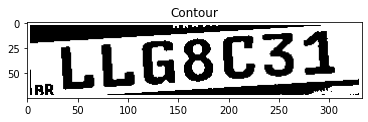

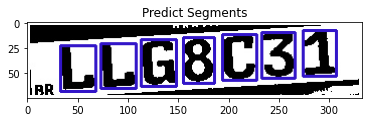

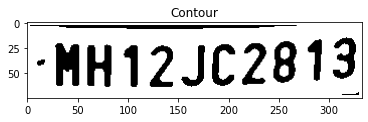

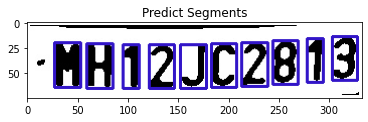

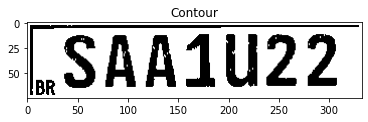

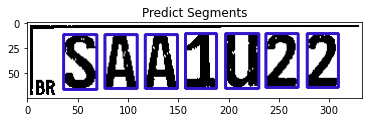

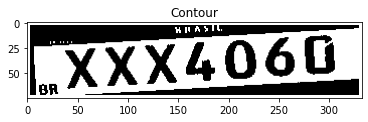

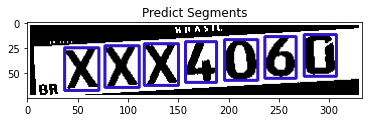

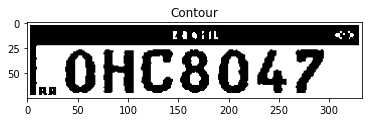

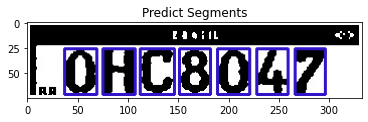

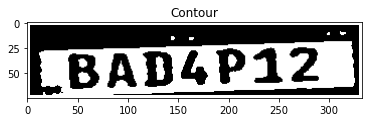

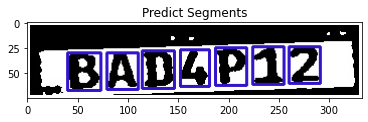

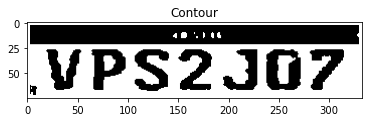

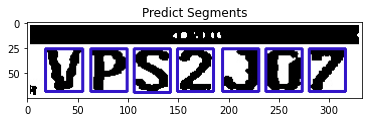

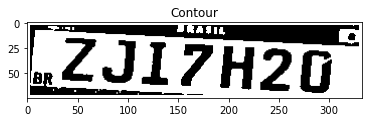

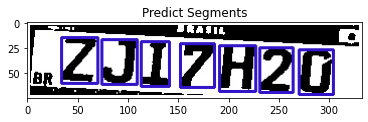

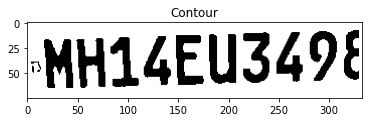

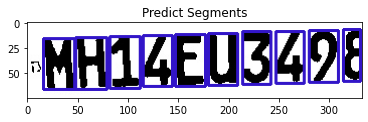

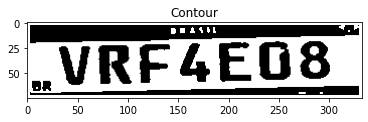

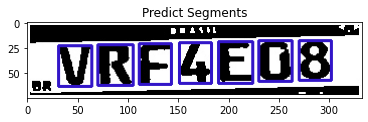

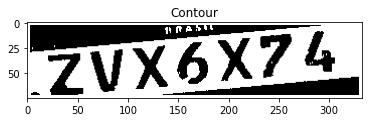

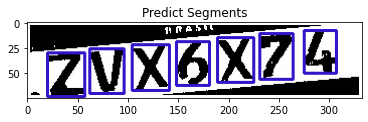

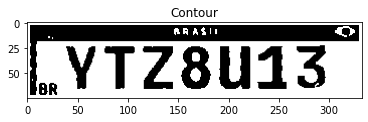

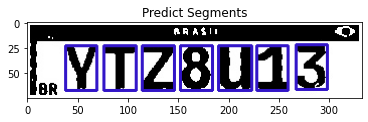

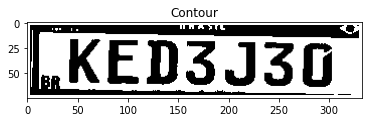

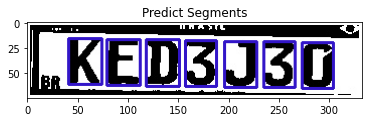

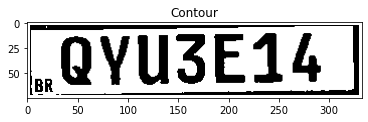

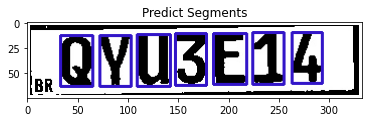

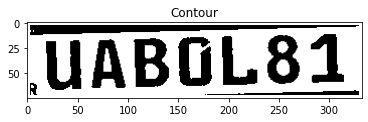

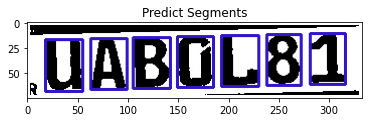

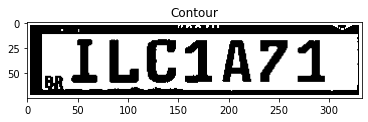

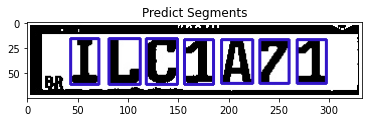

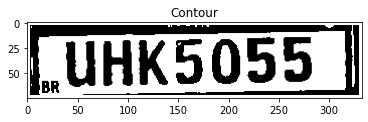

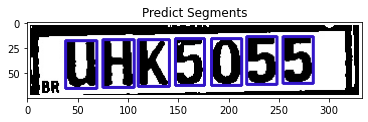

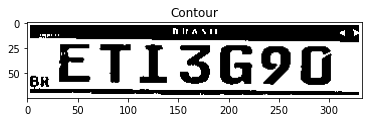

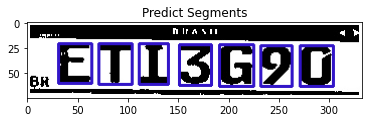

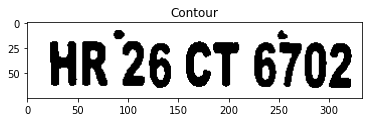

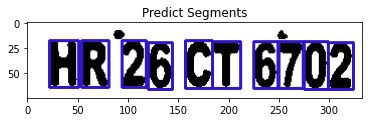

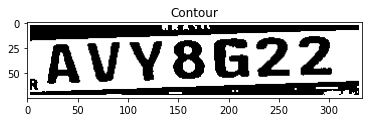

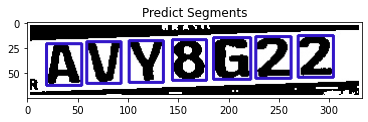

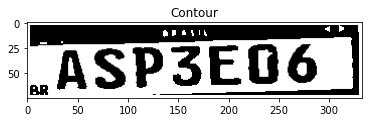

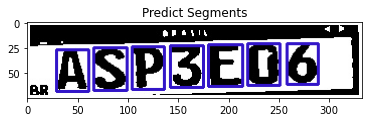

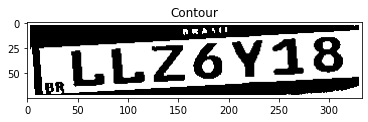

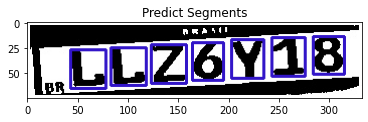

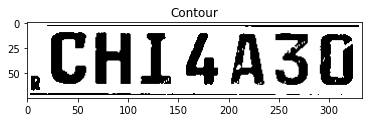

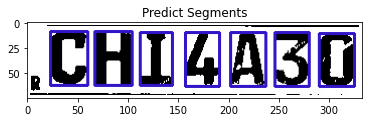

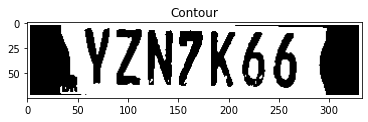

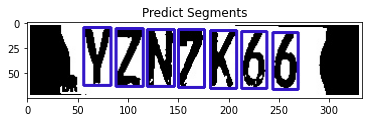

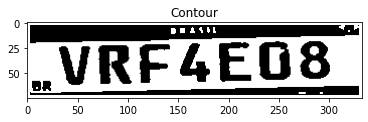

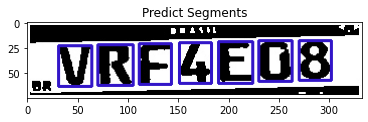

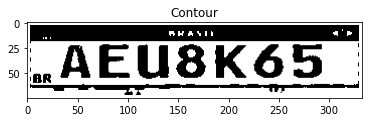

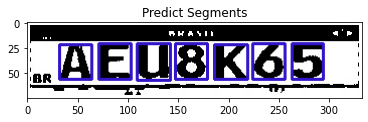

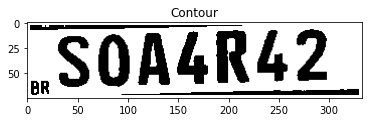

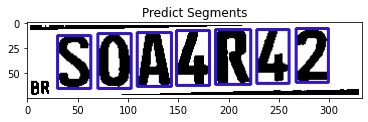

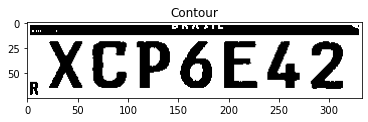

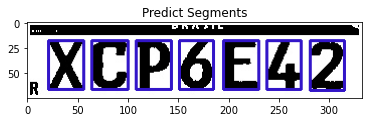

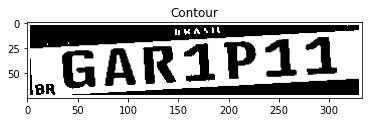

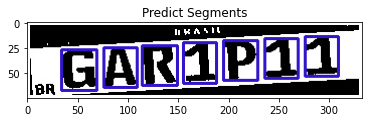

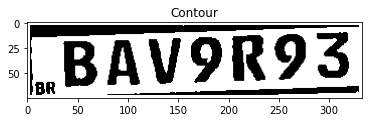

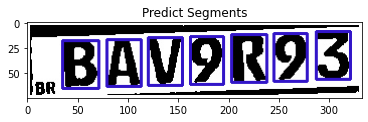

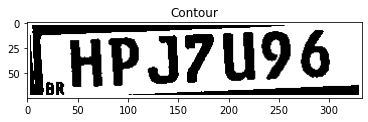

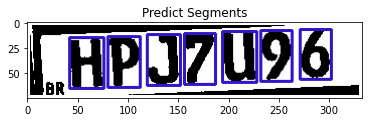

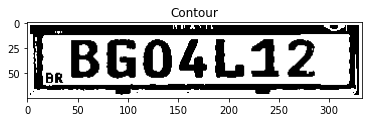

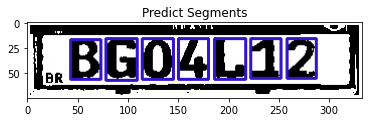

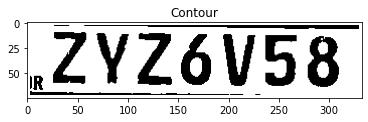

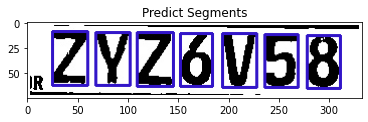

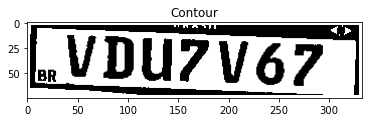

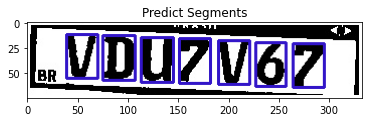

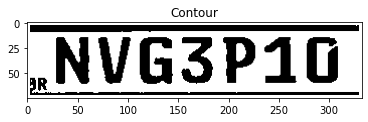

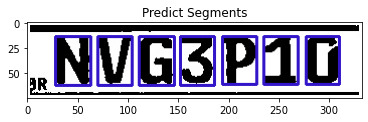

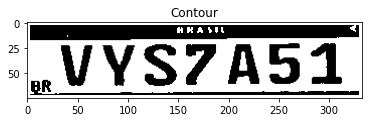

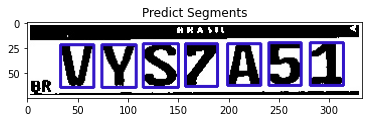

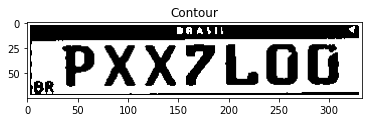

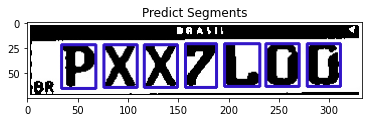

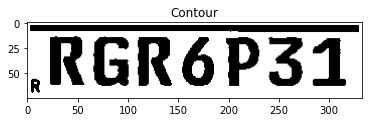

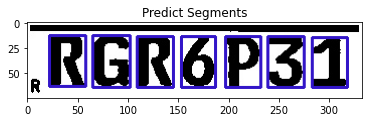

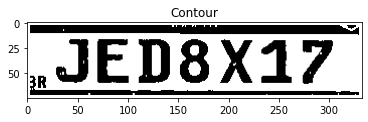

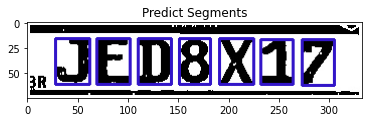

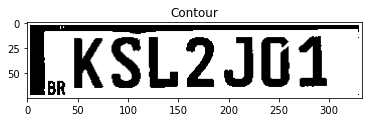

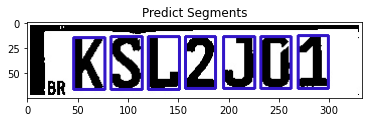

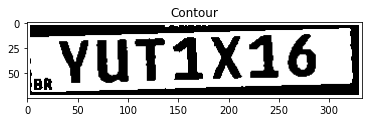

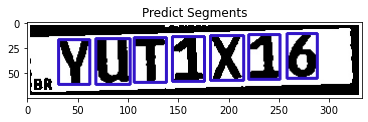

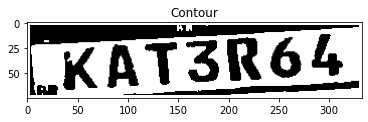

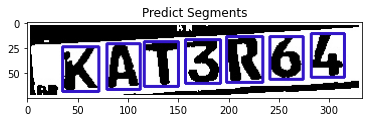

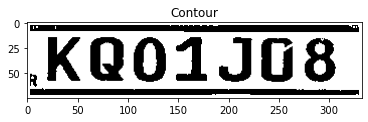

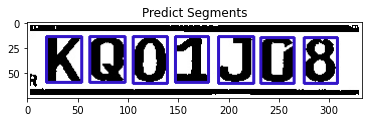

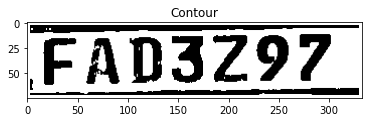

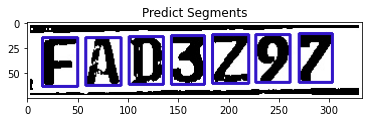

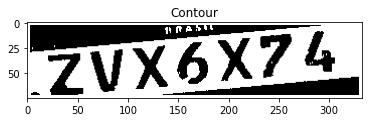

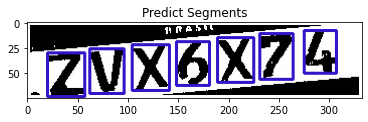

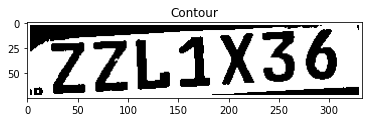

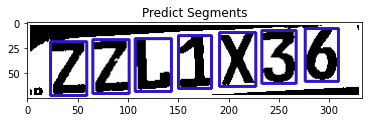

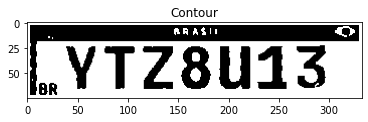

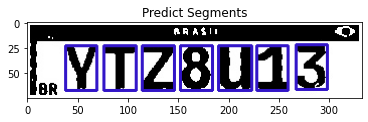

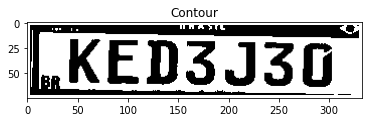

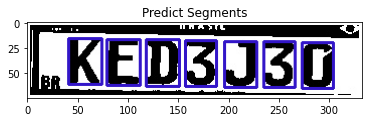

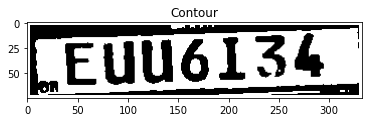

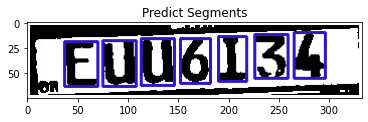

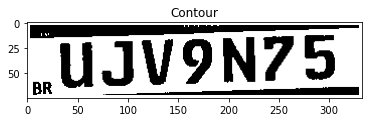

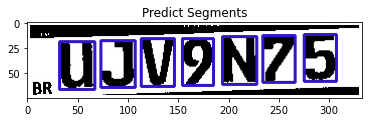

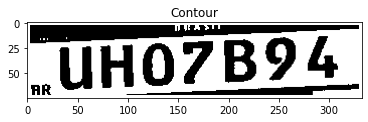

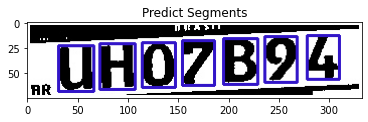

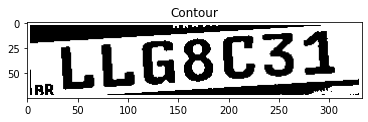

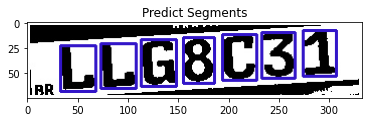

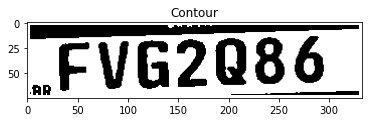

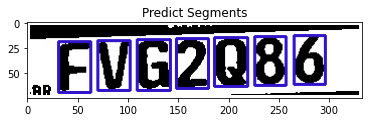

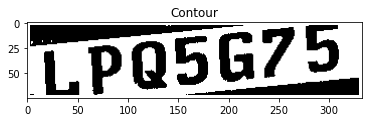

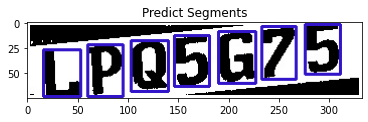

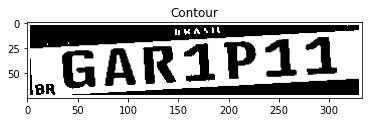

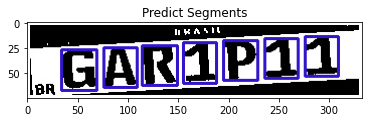

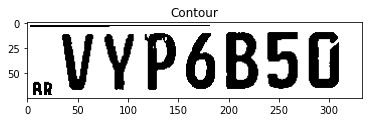

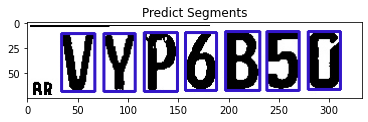

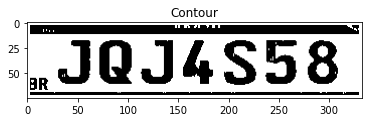

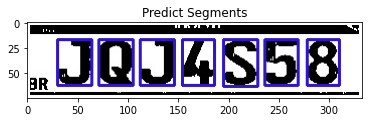

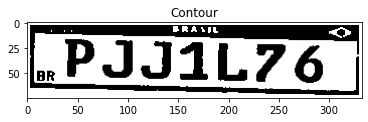

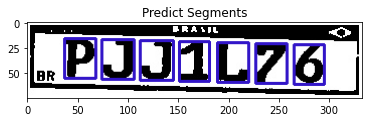

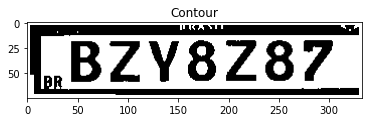

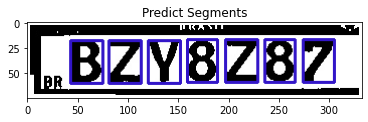

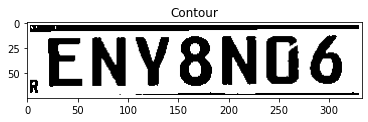

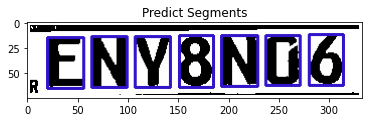

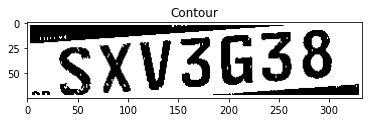

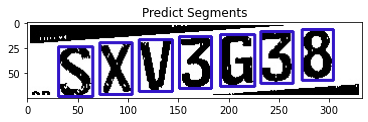

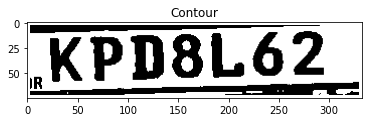

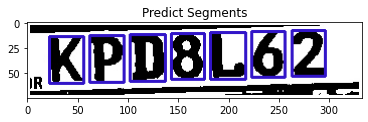

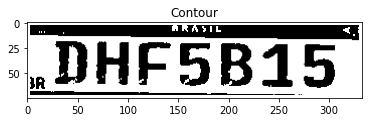

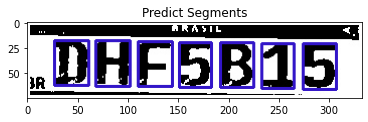

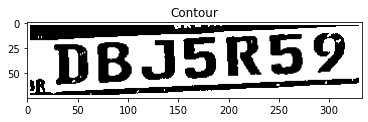

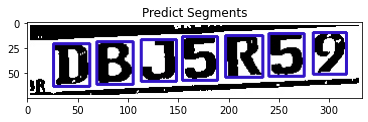

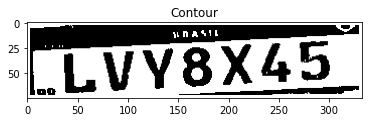

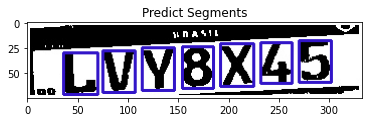

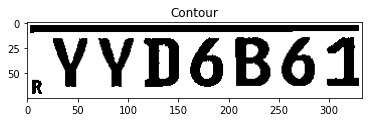

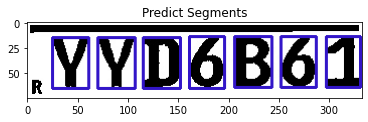

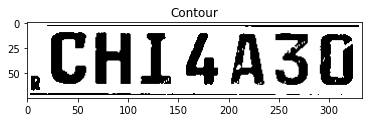

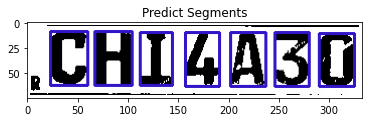

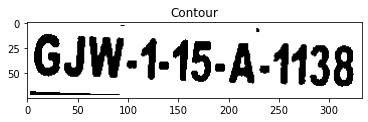

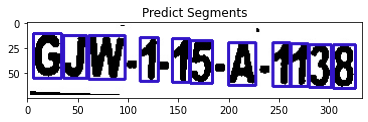

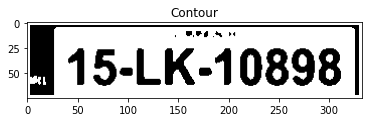

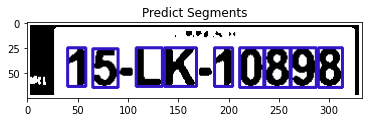

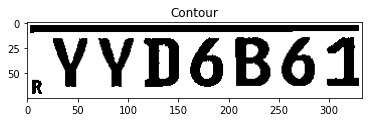

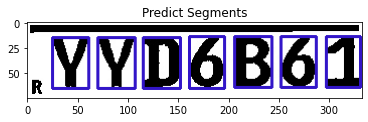

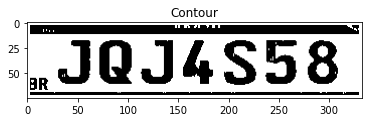

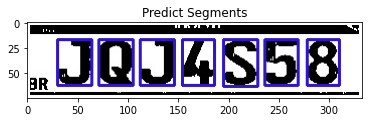

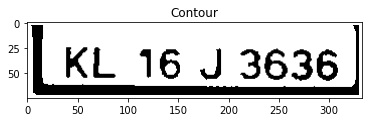

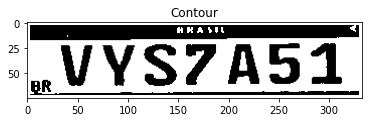

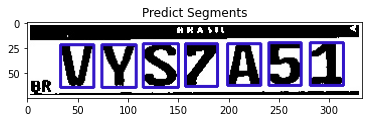

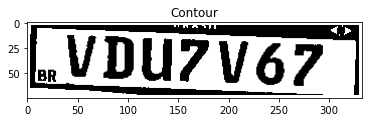

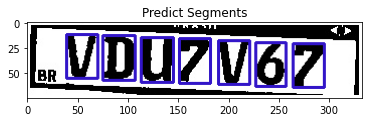

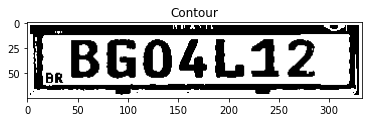

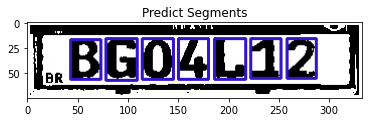

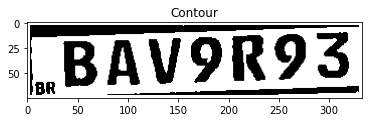

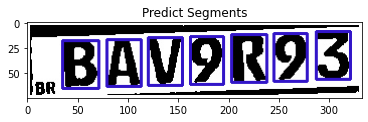

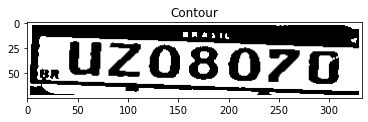

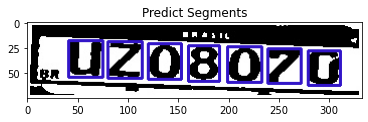

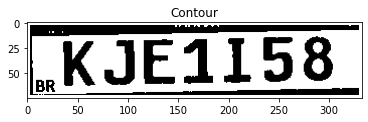

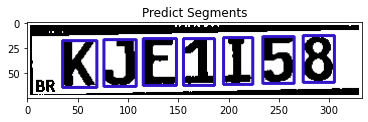

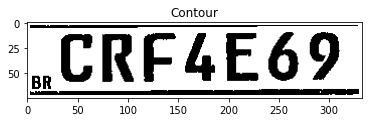

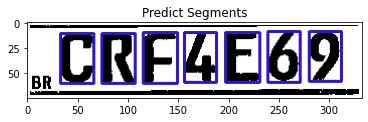

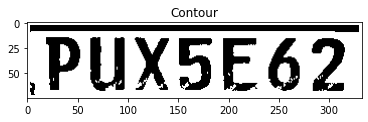

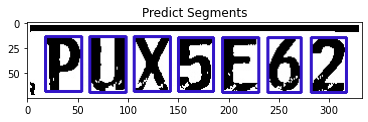

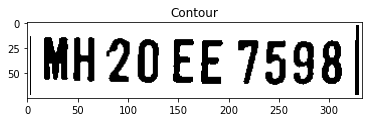

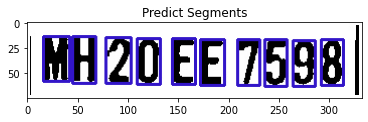

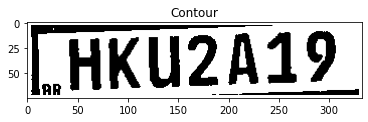

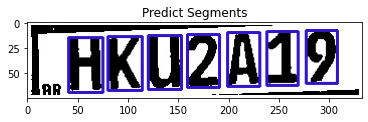

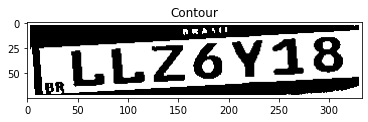

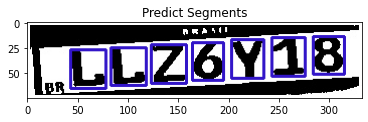

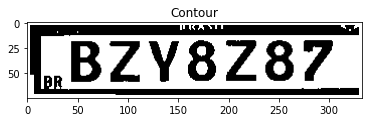

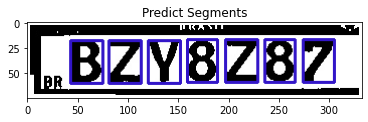

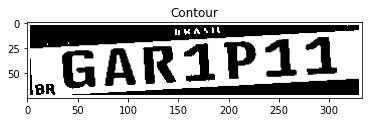

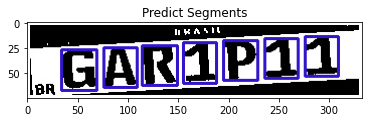

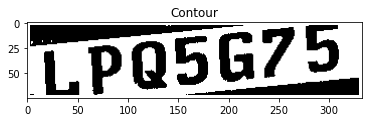

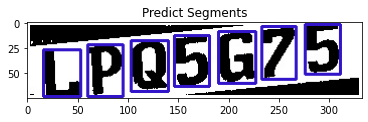

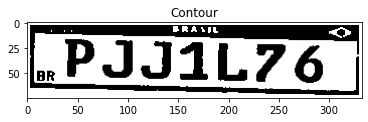

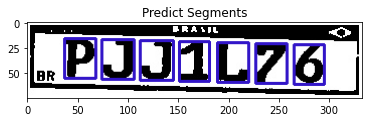

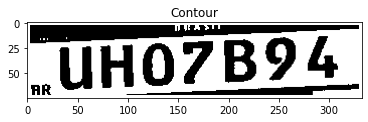

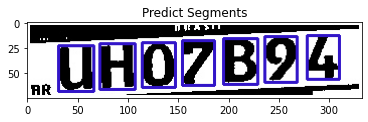

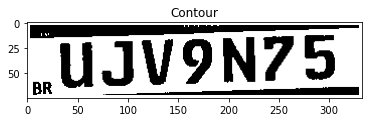

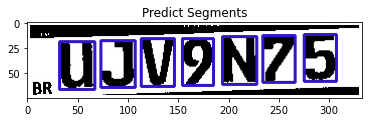

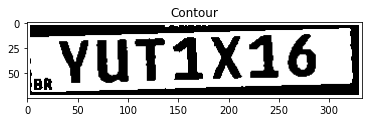

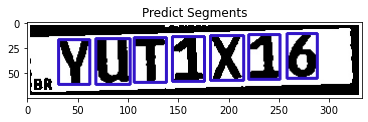

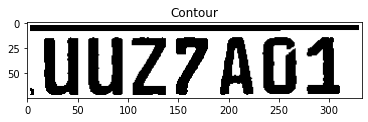

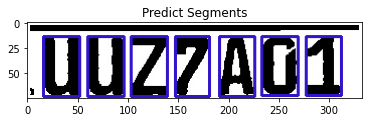

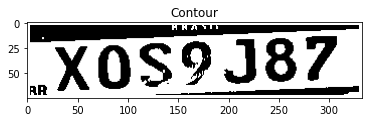

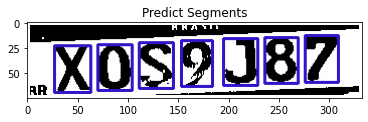

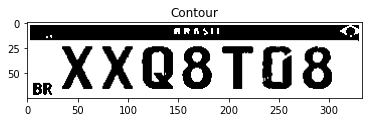

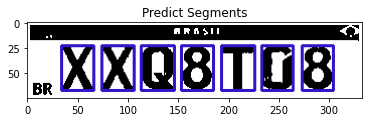

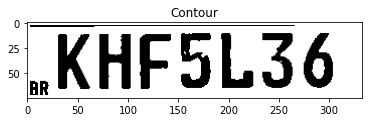

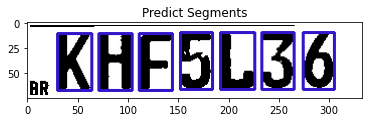

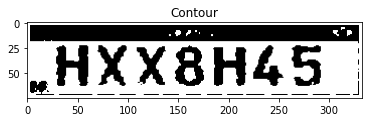

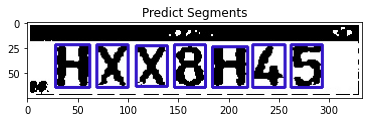

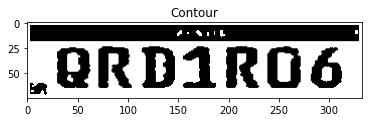

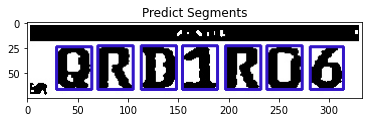

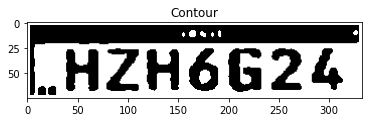

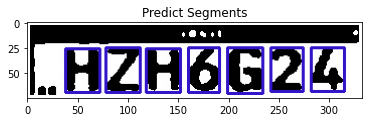

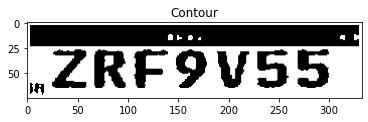

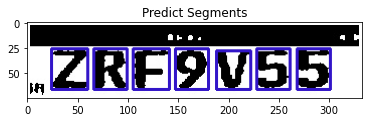

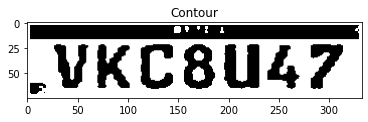

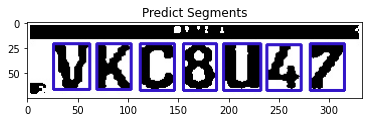

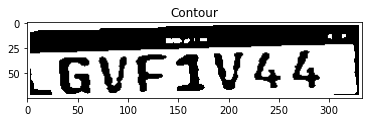

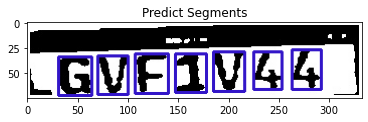

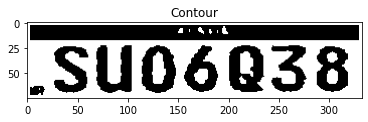

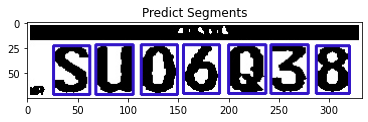

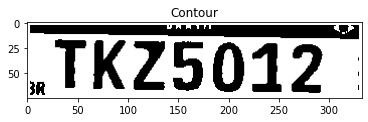

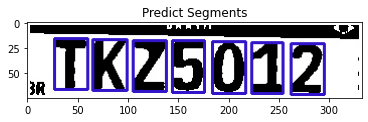

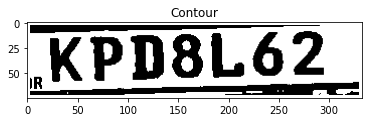

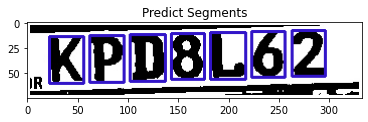

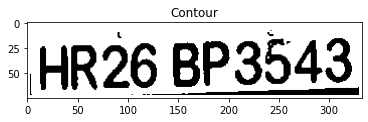

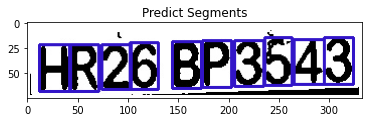

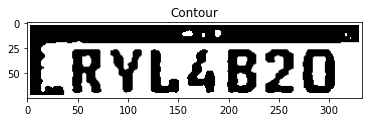

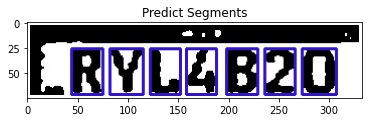

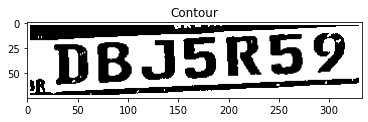

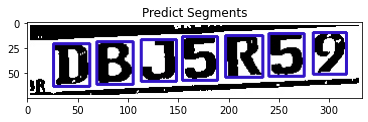

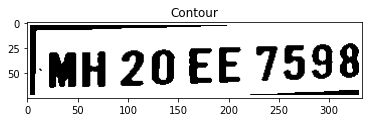

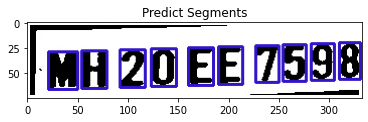

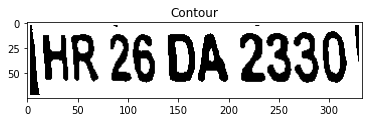

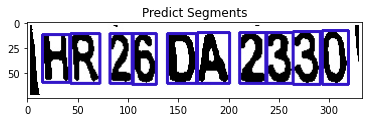

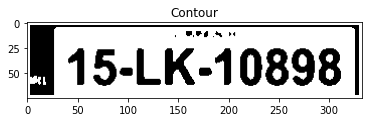

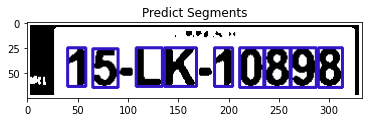

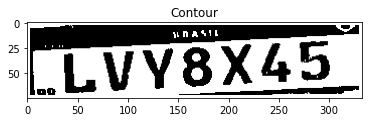

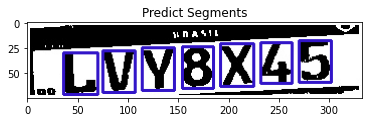

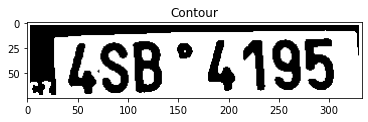

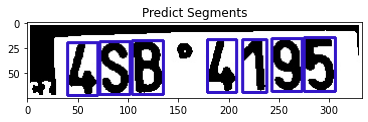

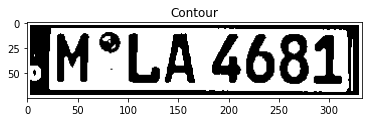

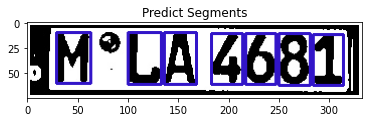

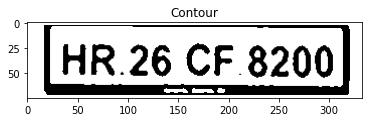

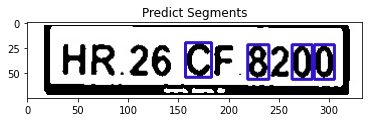

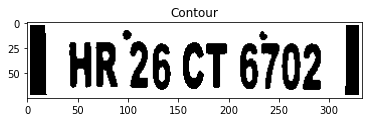

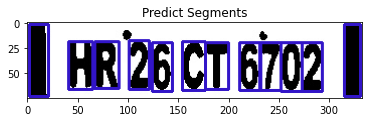

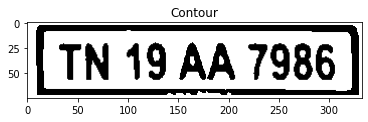

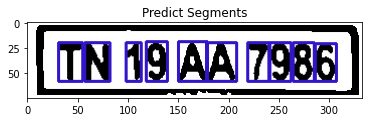

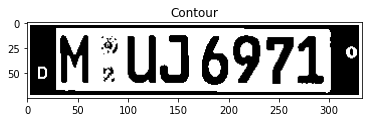

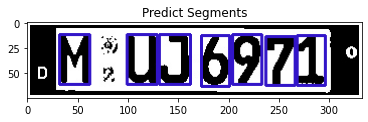

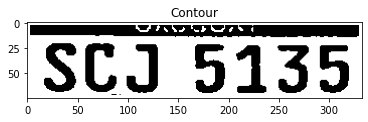

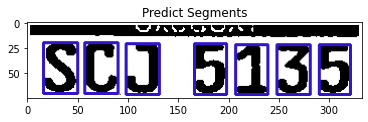

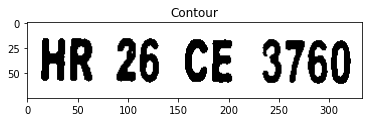

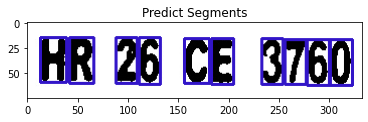

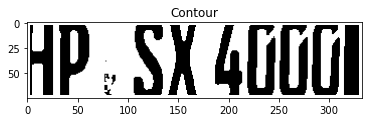

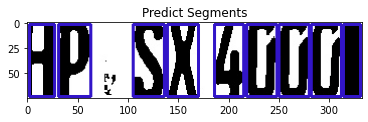

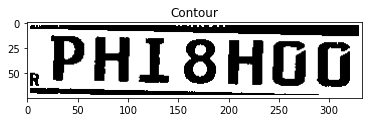

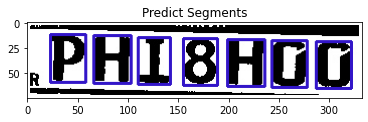

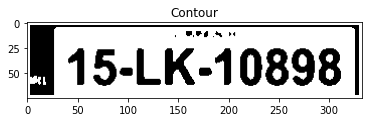

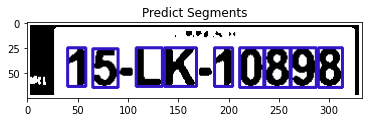

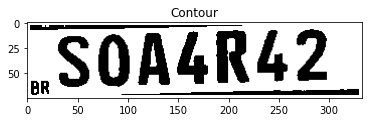

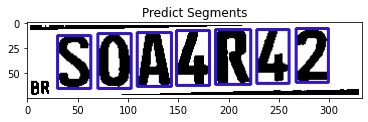

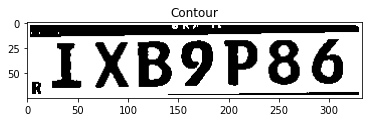

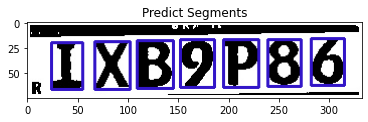

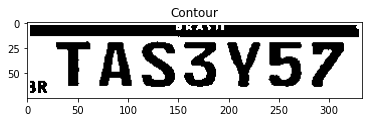

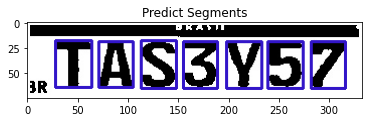

Accuracy: 0.7692307692307693%


In [36]:
file_list=os.listdir(r"D:/Sheikfaizalnumberplate/test_dataset/images")
count=1
for path in file_list:
#for entry in labels['ID']:
    input_path ='D:/Sheikfaizalnumberplate/test_dataset/images/'+path
    is_video = False
    no=path[:-4]
    row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    
    cap = cv2.VideoCapture(input_path)
    
    outputFile = input_path + '_yolo_out_py.jpg'

    while cv2.waitKey(1) < 0:

        # get frame from the video
        hasFrame, frame = cap.read() #frame: an image object from cv2

        # Stop the program if reached end of video
        if not hasFrame:
            break

        # Create a 4D blob from a frame.
        try:
            blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
        except:
            break

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))

        # Remove the bounding boxes with low confidence
        cropped = postprocess(frame, outs)
        if cropped is not None:
            # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
            t, _ = net.getPerfProfile()
            label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
            
            char=segment_characters(cropped)
            # Predicting the output
            def show_results(count):
                plate = ''
                return plate, count
            plate, count = show_results(count)

            
print("Accuracy: " + str((count / 130) * 100) + "%")


In [37]:
file_list = os.listdir(r"D:/Sheikfaizalnumberplate/test_dataset/images")
count = 1

for path in file_list:
    input_path = 'D:/Sheikfaizalnumberplate/test_dataset/images/' + path
    is_video = False
    no = path[:-4]
    row = labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    
    cap = cv2.VideoCapture(input_path)
    outputFile = input_path + '_yolo_out_py.jpg'

    while cv2.waitKey(1) < 0:
        # get frame from the video
        hasFrame, frame = cap.read() #frame: an image object from cv2

        # Stop the program if reached end of video
        if not hasFrame:
            break

        # Create a 4D blob from a frame.
        try:
            blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
        except:
            break

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))

        # Remove the bounding boxes with low confidence
        cropped = postprocess(frame, outs)
        if cropped is not None:
            # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
            t, _ = net.getPerfProfile()
            label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
            
            # Segment the characters and recognize the number plate
            plate, count = show_results(count)
            
print("Accuracy: " + str((count/130)*100) + "%")


Accuracy: 0.7692307692307693%


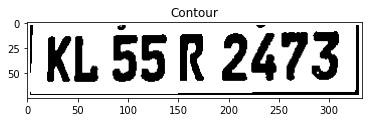

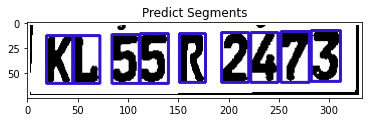

error: OpenCV(4.5.1) d:\bld\libopencv_1612623629519\work\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xeb399abc::Set<1,-1,-1>,struct cv::impl::A0xeb399abc::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [38]:
import os
import cv2
import pytesseract
from pytesseract import Output

file_list = os.listdir(r"D:/Sheikfaizalnumberplate/test_dataset/images")
count = 1

for path in file_list:
    input_path = 'D:/Sheikfaizalnumberplate/test_dataset/images/' + path
    no = path[:-4]
    row = labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]

    cap = cv2.VideoCapture(input_path)
    outputFile = input_path + '_yolo_out_py.jpg'

    while cv2.waitKey(1) < 0:
        hasFrame, frame = cap.read()

        if not hasFrame:
            break

        try:
            blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)
        except:
            break

        net.setInput(blob)
        outs = net.forward(getOutputsNames(net))
        cropped = postprocess(frame, outs)

        if cropped is not None:
            t, _ = net.getPerfProfile()
            label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())

            char = segment_characters(cropped)
            
            # Perform OCR on the segmented characters
            plate = ''
            for char_img in char:
                # Convert the character image to grayscale
                char_img_gray = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)

                # Perform OCR using pytesseract
                custom_config = r'--oem 3 --psm 6'
                result = pytesseract.image_to_string(char_img_gray, config=custom_config)

                # Append the recognized character to the plate string
                plate += result.strip()

                # Display the recognized character
                print("Recognized character:", result.strip())

            # Display the complete plate
            print("License Plate:", plate)

print("Accuracy: " + str((count / 130) * 100) + "%")
